In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

Data Size After Cleaning: 807
MSE: 296.85150016248383
R2 Score: 0.8592591544861705


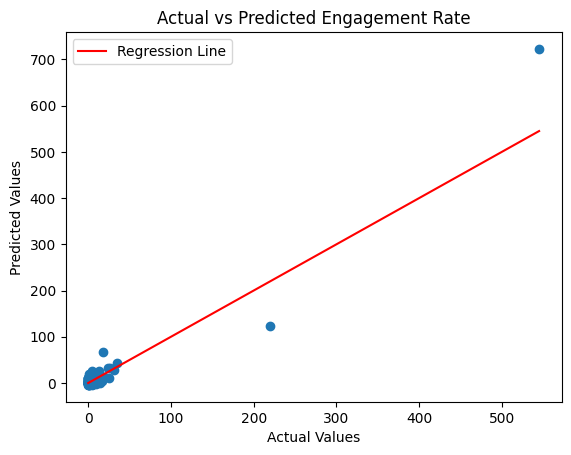

In [5]:
df = pd.read_csv("merged_cleaned.csv")

df_cleaned = df[df["Posting_Frequency(60Days)"] != 0].copy()

q1 = df_cleaned["Posting_Frequency(60Days)"].quantile(0.25)
q3 = df_cleaned["Posting_Frequency(60Days)"].quantile(0.75)
IQR = q3-q1

df_cleaned = df_cleaned[(df_cleaned["Posting_Frequency(60Days)"] >= q1 - IQR * 5.5) & (df_cleaned["Posting_Frequency(60Days)"] <= q3 + 5.5 * IQR)].copy()
print(f"Data Size After Cleaning: {df_cleaned.shape[0]}")

df_cleaned["Image_Ratio"] = df_cleaned["Posts(Image)"] / df_cleaned["Posting_Frequency(60Days)"]
df_cleaned["Video_Ratio"] = df_cleaned["Posts(Video)"] / df_cleaned["Posting_Frequency(60Days)"]
df_cleaned["Carousel_Ratio"] = df_cleaned["Posts(Carousel)"] / df_cleaned["Posting_Frequency(60Days)"]
df_cleaned["Like_Comment_Ratio"] = df_cleaned["Average_Likes"] / df_cleaned["Average_Comments"]
df_cleaned["Logged_Comments"] = np.log(df_cleaned["Average_Comments"])
df_cleaned["Logged_Likes"] = np.log(df_cleaned["Average_Likes"])
df_cleaned["Logged_Followers"] = np.log(df_cleaned["Followers"])
df_cleaned["Followers_Likes_Interaction"] = df_cleaned["Logged_Followers"] * df_cleaned["Logged_Likes"]
df_cleaned["Followers_Comments_Interaction"] = df_cleaned["Logged_Followers"] * df_cleaned["Logged_Comments"]

x = df_cleaned[["Followers_Likes_Interaction", "Logged_Followers", "Average_Engagement_Rate", "Video_Ratio", "Image_Ratio", "Carousel_Ratio", "Logged_Likes", "Like_Comment_Ratio", "Followers_Comments_Interaction"]]
y = df_cleaned[["Average_Engagement_Rate(60Days)"]]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

model = Ridge()
model.fit(x_train, y_train.values.ravel())

y_predict = model.predict(x_test)

mean_squared_error_value = mean_squared_error(y_test, y_predict)
r2_score_value = r2_score(y_test, y_predict)
print(f"MSE: {mean_squared_error_value}\nR2 Score: {r2_score_value}")

plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', label="Regression Line")
plt.scatter(y_test, y_predict)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Engagement Rate")

plt.legend()
plt.show()